<a href="https://colab.research.google.com/github/eckoecho/Prediction-of-Product-Sales/blob/Version-2/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>





#**Prediction of Product Sales**
**Author:**Echo Diaz

**Last Updated:** June 2023


# **Project Overview**


## Imports

In [105]:
#Importing the necessary libraries
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
## Models & evaluation metrics
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

## **Load and Inspect Data**

In [106]:
#Setting the path to pull our data
fpath = "Data/sales_predictions_2023.csv"

In [107]:
#Converting our CSV into a dataframe
df = pd.read_csv(fpath)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [108]:
#Checking for various aspects: column & row count, data types, and any nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## **Data Cleaning**

### Overview of Our Data

In [109]:
#Looking at the numbr of rows and columns
df.shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns.")

There are 8523 rows and 12 columns.


In [110]:
#Data Types for Each Feature
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

7 columns have objects as their data types.
5 columns have floats as their data types.
1 column is an integer as their data type.

### Drop Duplicates

In [111]:
#Checking for duplicates within all rows
duplicated_rows = df.duplicated()
duplicated_rows.sum()

0

There are no duplicates to drop.

In [112]:
#Looking throughout the rows for nulls
null_sums = df.isna().sum()
null_sums

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

The results show 2 columns with missing data: 
- `Item_Weight` 
- `Outlet_Size`

In [113]:
#This allows me to see if i should drop any columns with a lot of missing data
null_percentage = null_sums/len(df) * 100
null_percentage

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

### Categorical Columns Cleaning

In [114]:
#Fixing string inconsistencies
#First, obtaining all features with string values
str_cols = df.select_dtypes(include="object").columns
str_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

#### Value Counts

In [115]:
#Looping thru each column and getting value_counts to see out of place values in each feature
for col in str_cols:
    print(f"Value counts for {col}: ")
    print(df[col].value_counts())  
    #Increase readibility with new lines between results
    print("\n")


Value counts for Item_Identifier: 
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value counts for Item_Fat_Content: 
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value counts for Item_Type: 
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value counts for Outlet_Identifier: 
OUT027    935
OUT013    932
OUT049    930
OUT046

#### Cleaning `Item_Fat_Content`

In [116]:
rename_dict = {"low fat": "Low Fat",
               "LF": "Low Fat",
               "reg": "Regular"}

In [117]:
#Item_Fat_Content values are inconsistent, going to standardize with .str.replace
#Convert using .str.replace("old","new")
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(rename_dict, regex=True)
df['Item_Fat_Content'].value_counts()
#We now have standardized our Item_Fat_Content feature

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

#### Cleaning `Outlet_Size`

In [118]:
#Converting outlet size of "high" to "large"
df["Outlet_Size"].replace({"High":"Large"}, inplace=True)
df["Outlet_Size"].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

In [119]:
#Now our dataset has values for each feature
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Adjust the values from `Small`,`Medium`, `High` to `Small`, `Medium`, `Large`. 

In [120]:
#Replace "High" with "Large"
df['Outlet_Size'] = df['Outlet_Size'].replace({"High":"Large"})
#Get the value counts for our column
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
Large      932
Name: Outlet_Size, dtype: int64

### Numerical Stats After Cleaning

Taking a quick look at our numericals stats to ensure we don't have extreme outliers.

In [121]:
#For any numerical columns, I obtain the summary statistics of each (min, max, mean).
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# **Exploratory Data Analysis**

In [122]:
#Calling our dataframe
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,Large,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


### Numeric

In [123]:
nom_cols = df.select_dtypes("number").columns
nom_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

#### Item Outlet Sales

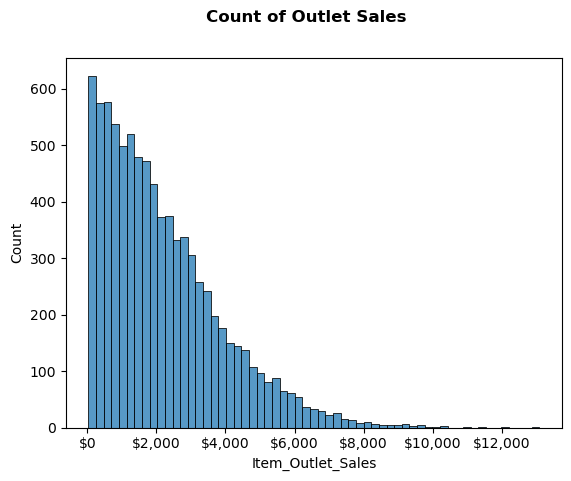

In [124]:
from seaborn.categorical import barplot
fig, ax = plt.subplots()
sns.histplot(df, x="Item_Outlet_Sales");
fig.suptitle("Count of Outlet Sales", fontweight="bold")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)

Our histogram provides an distribution overview of our target, the Outlet Sales, ranging from $0 to $13,000. This plot has a negative skew, meaning more stores sold between $0-$2000 than the number of stores that sold between $2000-$4000. This downward trend continues to the last range of $12,000 to $13,000. This shows us that it's possible to increase Outlet Sales beyond the average of $2,181. In my next steps, I plot each feature to show any relevance to increasing Outlet Sales.





In [125]:
#checking stats on Item Outlet Sales
df["Item_Outlet_Sales"].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

/var/folders/k6/7lk66pdn4_3f21m1dyjzs_dh0000gn/T/ipykernel_6063/4081924970.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45);


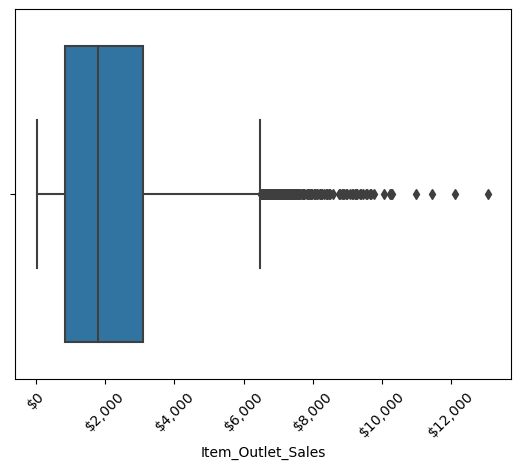

In [126]:
#Setting up subplot
fig, ax = plt.subplots()
#Displaying Outlet sales as boxplot
ax = sns.boxplot(df, x="Item_Outlet_Sales");
#Putting $ and , for Sales
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
#Rotating X-Axis Labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Showing numerical distribution of `Item_Oulet_Sales` (median, interquartile,min, max, and outliers).

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
    ```
    Numeric
    ```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute?
```
All values present
```
* If impute, with what?)
```
No need to impute.
```
* Is the feature constant or quasi-constant?
```
Neither
```
* What is the cardinality? Is it high (>10)?
```
Numeric so cardinality does not pertain.
```
* Would we know this feature before the target is determined?
```
Yes
```
* Is there a business case/understanding reason to exclude based on our business case?
```
This is our target, it's essential to our dataset since it is what we are trying to predict.
```


#### Item Weight

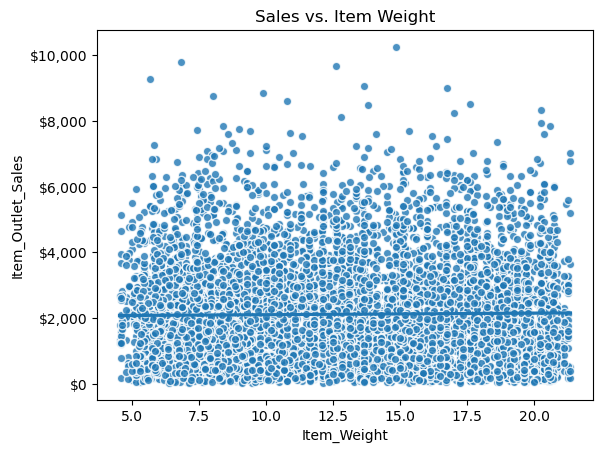

In [127]:
#sales vs. item_weight
fig, ax = plt.subplots()
sns.regplot(df, y="Item_Outlet_Sales", x="Item_Weight", scatter_kws={"edgecolor":"white"});
ax.set_title("Sales vs. Item Weight");
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

In [128]:
df["Item_Weight"].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Numeric
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? 
* If impute, with what?)
```
1,463 Null Values. I will impute this feature and use the mean since there are not too many outliers that will skew our mean.
```
* Is the feature constant or quasi-constant?
```
Values are neither constant or quasi-constant, they are all varied.
```

* What is the cardinality? Is it high (>10)?
```
This is a numeric column so cardinality is not relevant.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
We can exclude this because our trendline shows no correlation between Item Weight and Outlet Sales.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
No, Item Weight is not a predictor of Outlet Sales.
```
* Does this feature appear to be a predictor of the target?
```
No.
```

#### Item Visibility

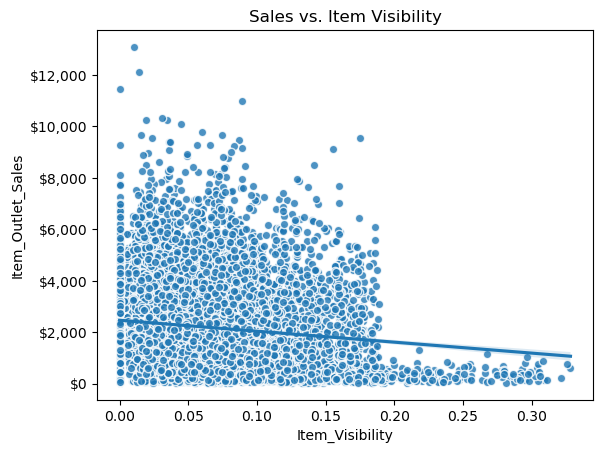

In [129]:
#sales vs. item_visiblity
fig, ax =plt.subplots()
sns.regplot(df, y="Item_Outlet_Sales", x="Item_Visibility", scatter_kws={"edgecolor":"white"});
ax.set_title("Sales vs. Item Visibility");
fmt = '${x:,.0f}'
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Numeric
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All the values are present. However, there are some 0.0000 values for our Item Visibility feature. Since items are not invisible, I impute 0.0000 with the mean value of this column.
```
* Is the feature constant or quasi-constant?
```
Neither.
```
* What is the cardinality? Is it high (>10)?
```
This is a numeric column so cardinality is not relevant.
```
* Would we know this feature before the target is determined?
```
Yes
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I wouldnt exclude it even though it does have a negative trendline to Outlet Sales.  I would inspect this a little closer before elimating from dataset.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
It's possible that it could influence Outlet Sales, more inspection is needed.
```
* Does this feature appear to be a predictor of the target?
```
Possibly.
```

#### Item MRP

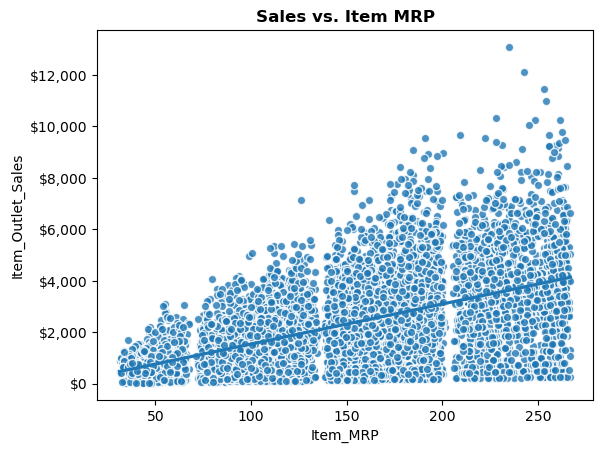

In [130]:
fig, ax = plt.subplots()
#sales vs. item_mrp
sns.regplot(df, y="Item_Outlet_Sales", x="Item_MRP", scatter_kws={"edgecolor":"white"});
ax.set_title("Sales vs. Item MRP", fontweight="bold");
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Numeric
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All values are present.
```
* Is the feature constant or quasi-constant?
```
Neither.
```
* What is the cardinality? Is it high (>10)?
```
This is a numeric column so cardinality is not relevant.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would *not* exclude this feature.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
Yes.
```
* Does this feature appear to be a predictor of the target?
```
Yes, we are showing a positive trendline when comparing Item MRP to Outlet Sales.
```

#### Outlet Est. Year

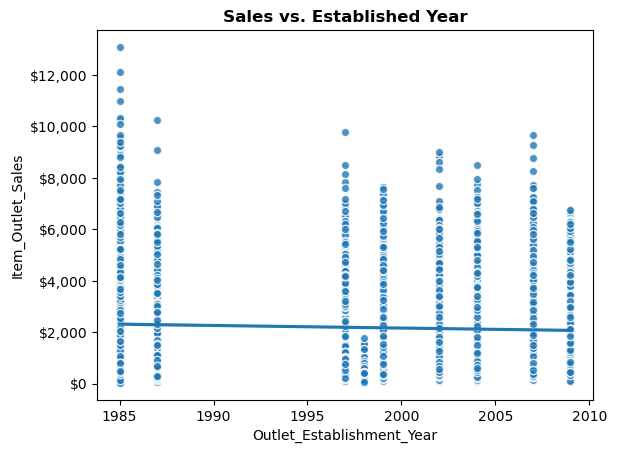

In [131]:
fig, ax = plt.subplots()
#sales vs. outlet_year_est
sns.regplot(df, y="Item_Outlet_Sales", x="Outlet_Establishment_Year", scatter_kws={"edgecolor":"white"});
ax.set_title("Sales vs. Established Year", fontweight="bold");
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Numeric
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
Values are all present.
```
* Is the feature constant or quasi-constant?
```
This could be considered quasi-constant since there are only a handful of values.
```
* What is the cardinality? Is it high (>10)?
```
This is a numeric column so cardinality is not relevant.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would exclude this from the dataset because this is not something that business owners can change.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
Its possible that longer established outlets have higher outlet sales.
```
* Does this feature appear to be a predictor of the target?
```
It may be a predicter, however it's not something a business owner can adjust.
```

### Categorical

In [132]:
cat_cols = df.select_dtypes("object").columns
cat_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

#### Item Identifier

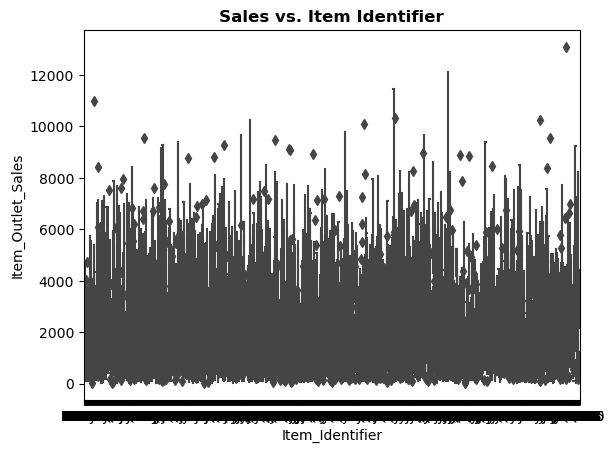

In [133]:
fig, ax = plt.subplots()
sns.boxplot(df, y="Item_Outlet_Sales", x="Item_Identifier");
ax.set_title("Sales vs. Item Identifier", fontweight="bold");

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Categorical, nominal
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All values present.
```
* Is the feature constant or quasi-constant?
```
Neither.
```
* What is the cardinality? Is it high (>10)?
```
Not a high cardinality feature.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would exclude this based on the incoherent visualization.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
I would not expect this to influence the Outlet Sales.
```
* Does this feature appear to be a predictor of the target?
```
Does *not* appear to be a predictor of Outlet Sales.
```

#### Item Fat Content

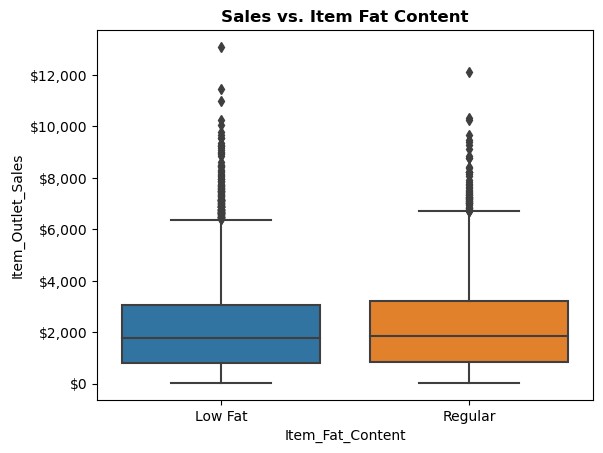

In [134]:
fig, ax = plt.subplots()
sns.boxplot(df, y="Item_Outlet_Sales", x="Item_Fat_Content");
ax.set_title("Sales vs. Item Fat Content", fontweight="bold")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Categorical, nominal.
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All values present.
```
* Is the feature constant or quasi-constant?
```
It is quasi constant since it only has 2 values: Low Fat, Regular
```
* What is the cardinality? Is it high (>10)?
```
Does not have a high cardinality.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would exclude this feature since both Low Fat and Regular have the same amount of Outlet Sales.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
I don't expect this feature to influence our Outlet Sales because our choices have the same median for Outlet Sales.
```
* Does this feature appear to be a predictor of the target?
```
No.
```

#### Item Type

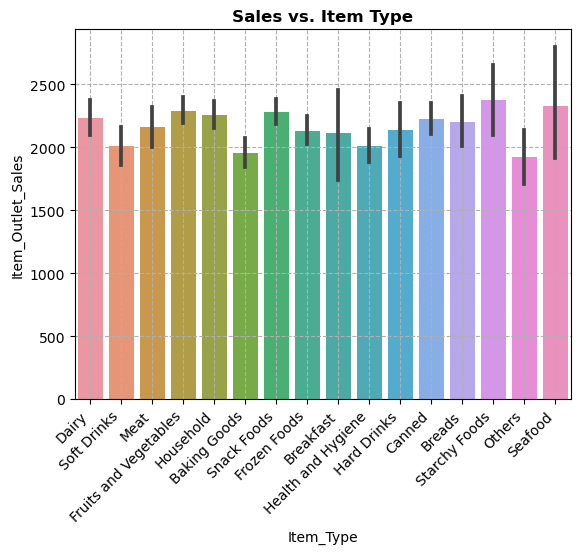

In [135]:
fig, ax = plt.subplots()
sns.barplot(df, y="Item_Outlet_Sales", x="Item_Type");
ax.set_title("Sales vs. Item Type", fontweight="bold")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.grid(ls="--");

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Categorical, nominal
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All values present.
```
* Is the feature constant or quasi-constant?
```
Neither.
```
* What is the cardinality? Is it high (>10)?
```
Yes, it does. However, this data is relevant to our target.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would *not* exclude this feature because it is an aspect that our stakeholders can control.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
Yes, some items seem to have higher outlet sales than others.
```
* Does this feature appear to be a predictor of the target?
```
Yes.
```

#### Outlet Identifier

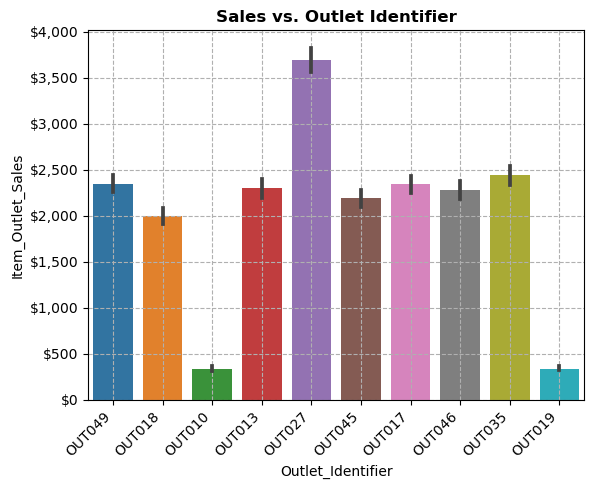

In [136]:
fig, ax = plt.subplots()
sns.barplot(df, y="Item_Outlet_Sales", x="Outlet_Identifier")
ax.set_title("Sales vs. Outlet Identifier", fontweight="bold")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.grid(ls="--");

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Categorical, nominal
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All values are present.
```
* Is the feature constant or quasi-constant?
```
Neither.
```
* What is the cardinality? Is it high (>10)?
```
This feature does have a high cardinality
```
* Would we know this feature before the target is determined?
```
Its possible to inspect the difference between a high & low earner such as `Out027` and `Outlet10`.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would *not* exclude this feature as it can be closer inspected on what makes `Outlet10` a high earner.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
Not directly an influencer but could have qualities that influence Outlet Sales.
```
* Does this feature appear to be a predictor of the target?
```
It is possible.
```

#### Outlet Size

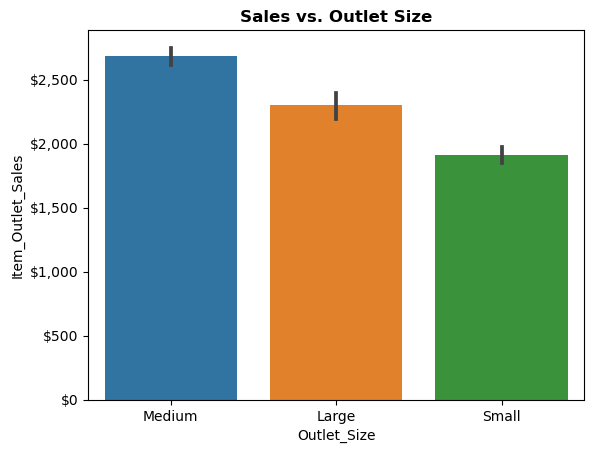

In [137]:
fig, ax = plt.subplots()
sns.barplot(df, y="Item_Outlet_Sales", x="Outlet_Size")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_title("Sales vs. Outlet Size", fontweight="bold");

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Categorical, ordinal
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
2,410 Null Values
```
* Is the feature constant or quasi-constant?
```
Quasi-constant since it only has 3 choices.
```
* What is the cardinality? Is it high (>10)?
```
No.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would *not* exclude this from our data set.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
It's possible that a medium size outlet does better sales than smaller or bigger outlets.
```
* Does this feature appear to be a predictor of the target?
```
Yes.
```

#### Outlet Location Type

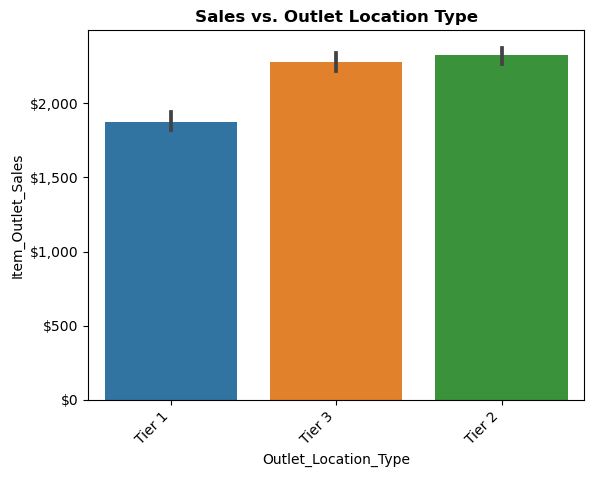

In [138]:
fig, ax = plt.subplots()
sns.barplot(df, y="Item_Outlet_Sales", x="Outlet_Location_Type");
ax.set_title("Sales vs. Outlet Location Type", fontweight="bold")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Categorical, ordinal
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All values present.
```
* Is the feature constant or quasi-constant?
```
Quasi-constant.
```
* What is the cardinality? Is it high (>10)?
```
No.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would *not* exclude this from our dataset.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
Having a Tier 1 store doesn't necessary produce more sales. Let's take a look at our numeric correlations to see positive trends in our features.
```
* Does this feature appear to be a predictor of the target?
```
Yes.
```

#### Outlet Type

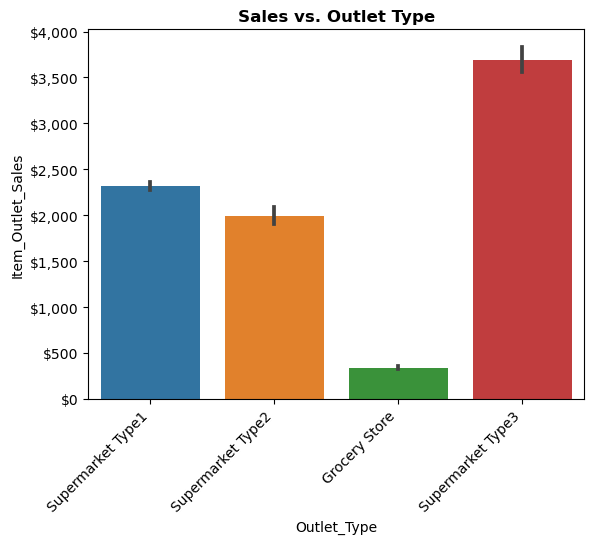

In [139]:
fig, ax = plt.subplots()
sns.barplot(df, y="Item_Outlet_Sales", x="Outlet_Type");
ax.set_title("Sales vs. Outlet Type", fontweight="bold")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

* What type of feature is it? (Categorical (nominal), ordinal, numeric)
```
Categorical, nominal
```
* How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
```
All values present.
```
* Is the feature constant or quasi-constant?
```
No.
```
* What is the cardinality? Is it high (>10)?
```
Neither.
```
* Would we know this feature before the target is determined?
```
Yes.
```
* Is there a business case/understanding reason to exclude based on our business case?
```
I would *not* exclude this from our dataset.
```
* Based on your business understanding, would you expect this feature to be a predictor of the target?
```
Yes, `Supermarket Type 3` has significantly higher sales than other Outlet Types.
```
* Does this feature appear to be a predictor of the target?
```
Yes.
```

## Heatmap

In [140]:
#Finding correlation between our numeric data
corr = df.corr(numeric_only = True)
#Rounding off for visibility
corr.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.03,-0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.03,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,-0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00


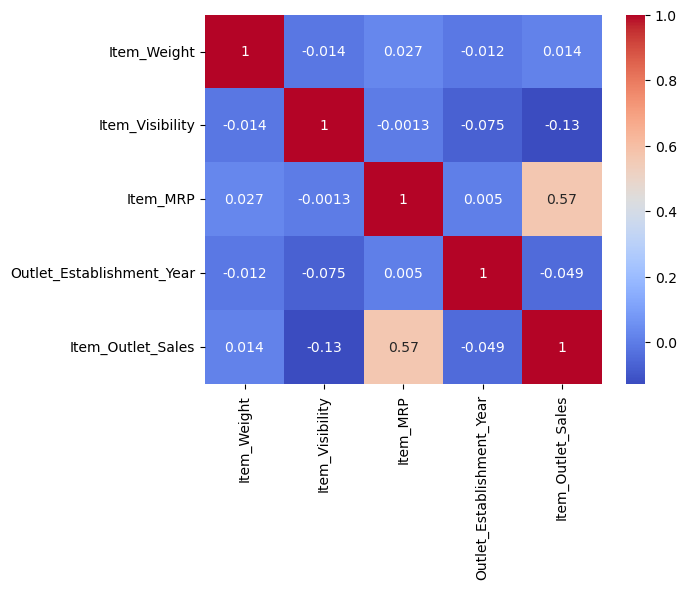

In [141]:
#Creating a heatmap to easily show correlations in our numeric data
sns.heatmap(corr, cmap="coolwarm", annot=True);

Our heatmap easily shows the weak and strong correlation between two variables.  For instance, `Item_Outlet_Sales` & `Item_Weight` have a weak correlation together than `Item_Outlet_Sales` & `Item_MRP`, which has a moderately strong correlation.

# **Explanatory Data Analysis**

* Our goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.

* Our target is to increase item sales per outlet, so we inspect the price point of items to see if that contributes to higher sales.

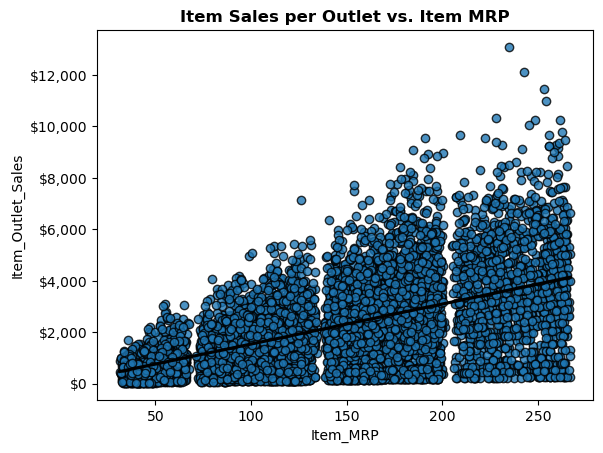

In [142]:
#Plotting Sales vs. MRP
ax=sns.regplot(df, y="Item_Outlet_Sales", x="Item_MRP", scatter_kws={"edgecolor":"black"}, line_kws={"color":"black"})
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_title("Item Sales per Outlet vs. Item MRP", fontweight="bold");

* Outlets with sales from $0 - $2000 mostly sell cheaper products as our points are in tighter clusters then more expensive items.

* This point is also displayed on our outlets that sell more, they sell more expensive items.

* Outlets selling more expensive items lead to higher sales.  But, what *type of foods* are contributing to higher sales?  Next, we explore those categories.

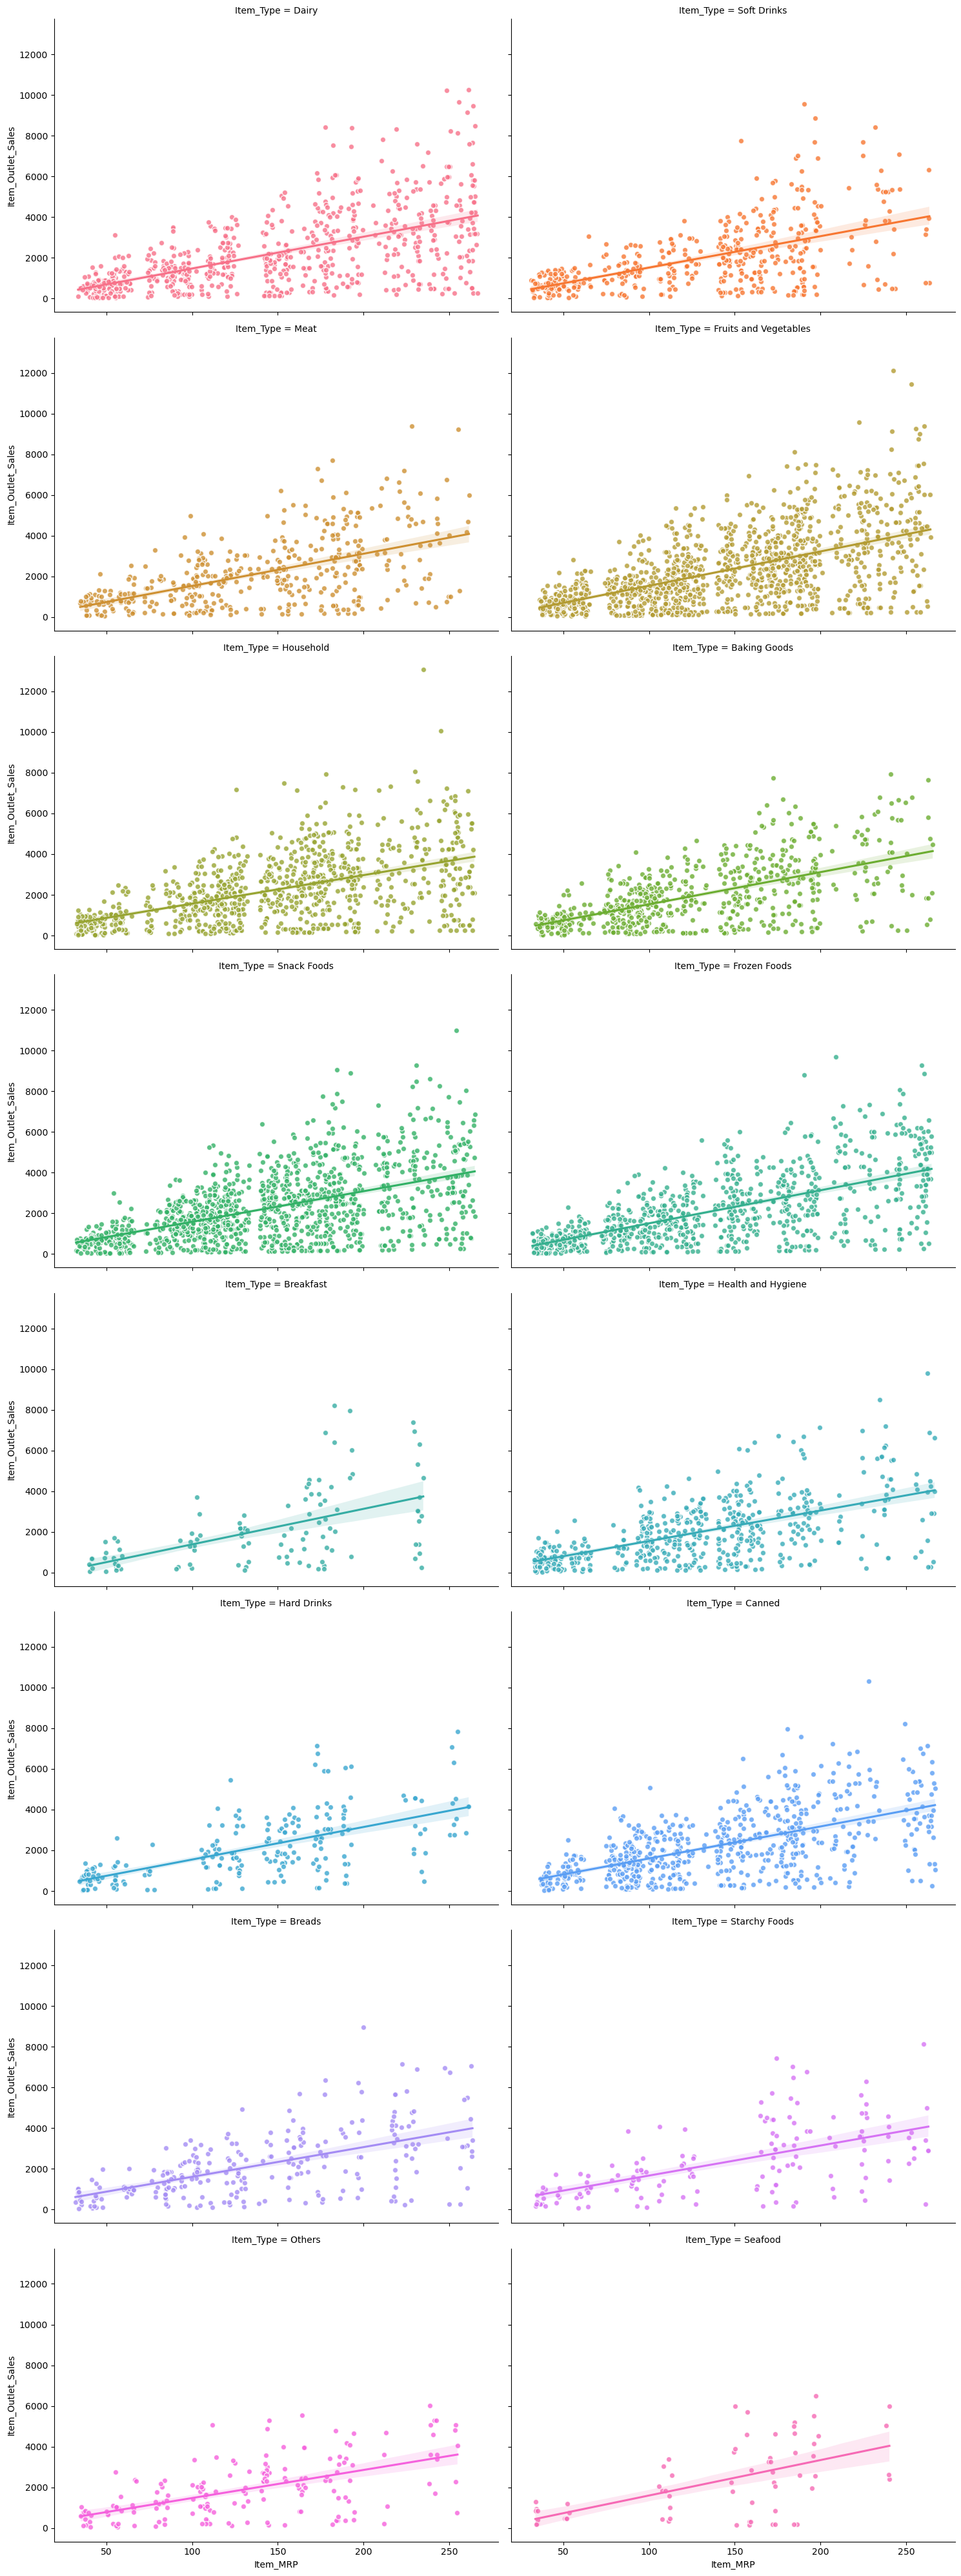

In [143]:
#Plotting each Item Type
g = sns.lmplot(df, y="Item_Outlet_Sales", x="Item_MRP", hue="Item_Type", 
               scatter_kws={"edgecolor":"white"},aspect=1.5, 
               col="Item_Type", col_wrap=2)

* At a quick glance, we can see the different categories of food vs. sales.  All have positive trendline but the more scatterplots indicate more item sales.  Snack Food, Fruites and Veggies, and Dairy have more scatterplots indicating these foods sell more.

/var/folders/k6/7lk66pdn4_3f21m1dyjzs_dh0000gn/T/ipykernel_6063/3194255547.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


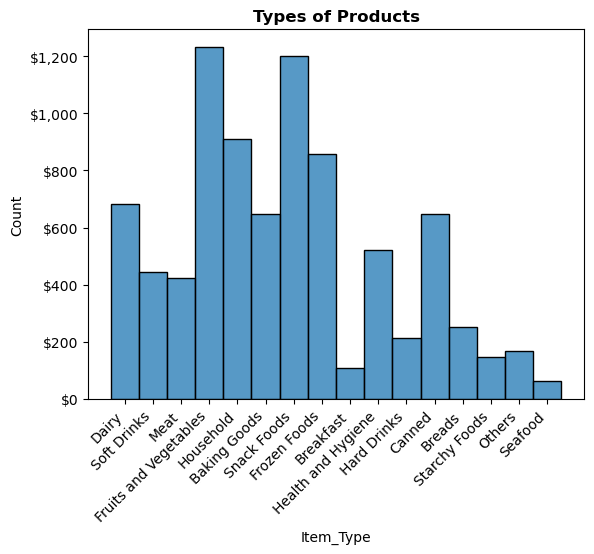

In [144]:
fig, ax = plt.subplots()
ax=sns.histplot(df, x="Item_Type");
ax.set_title("Types of Products", fontweight="bold");
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

* This shows the quantity of items per food category. We see that the top counts of food categories include:

    1. Fruits and Vegetables
    2. Snack Foods
    3. Household
    4. Frozen Foods




------------------------------

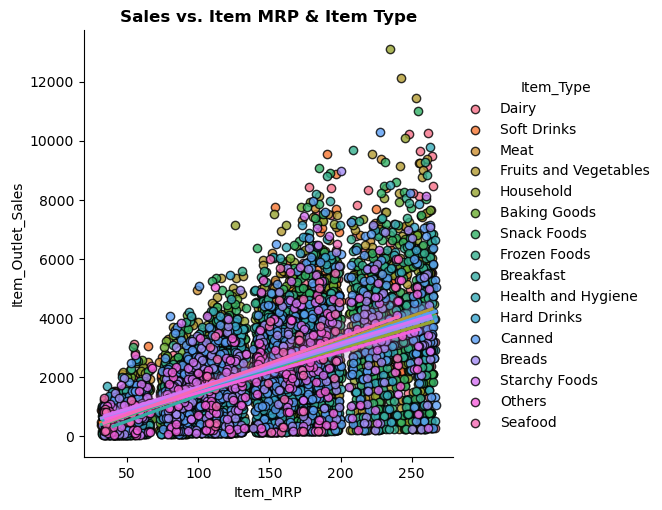

In [145]:
sns.lmplot(df, y="Item_Outlet_Sales", x="Item_MRP", hue="Item_Type", scatter_kws={"edgecolor":"black"});
plt.title("Sales vs. Item MRP & Item Type", fontweight="bold");

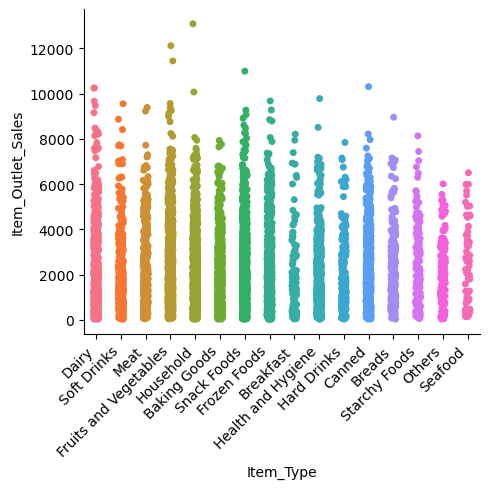

In [146]:
g = sns.catplot(data=df, y="Item_Outlet_Sales", x="Item_Type", hue="Item_Type")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
g.set_xticklabels(label="Item_Type", rotation=45, ha="right");
g.tight_layout();

In this category plot, support strong sales for these Item Types:
* Dairy
* Fruits and Vegetables
* Snack Foods
* Canned


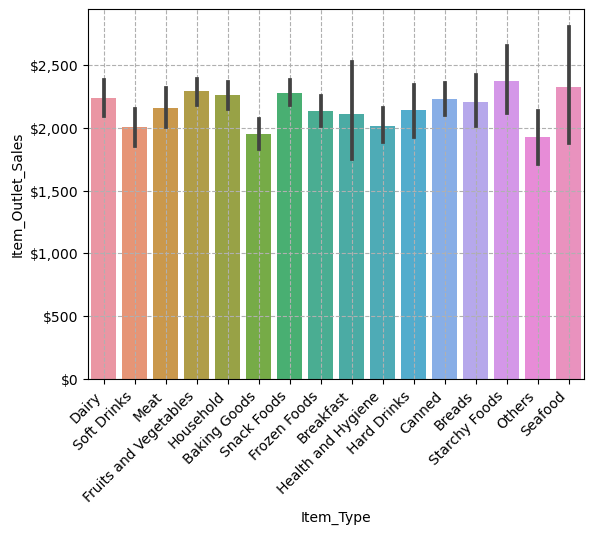

In [147]:
ax= sns.barplot(data=df, y="Item_Outlet_Sales", x="Item_Type");
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.grid(ls="--");

Shows the average number of outlet sales per food category. Remember the outliers arent shown here but, they will raise the average sales per category. Seafood is a good example of having high average sales but our solid black line means there are outliers that skew average. 

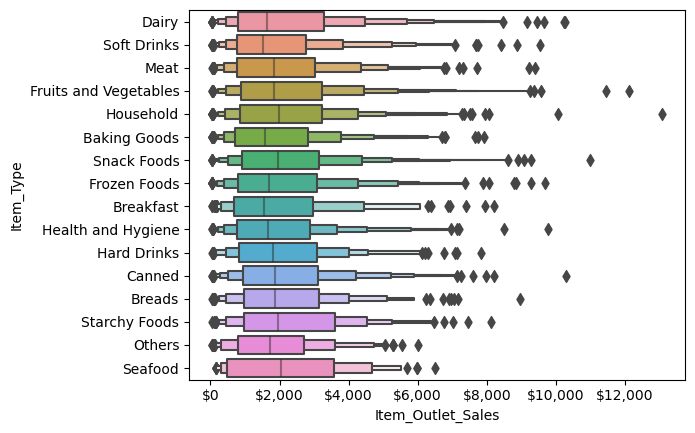

In [148]:
ax = sns.boxenplot(data=df, x="Item_Outlet_Sales", y="Item_Type")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

## Also order from great to least
Shows the middle range category vs the Outlet Sales. These shows the outliers that can contribute to greater the outlet sales.

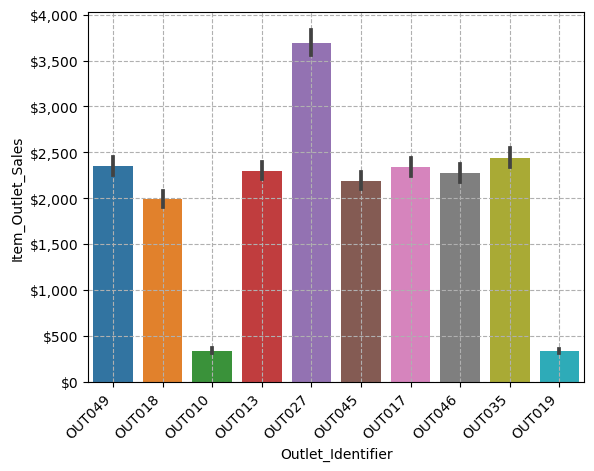

In [149]:
fig, ax = plt.subplots()
sns.barplot(df, y="Item_Outlet_Sales", x="Outlet_Identifier")
#Putting $ and , on Sales axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.grid(ls="--");

In [150]:
outlet27 = df["Outlet_Identifier"] == "OUT027"
df[outlet27]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
36,FDV20,NaN,Regular,0.059512,Fruits and Vegetables,128.0678,OUT027,1985,Medium,Tier 3,Supermarket Type3,2797.6916
38,FDX10,NaN,Regular,0.123111,Snack Foods,36.9874,OUT027,1985,Medium,Tier 3,Supermarket Type3,388.1614
...,...,...,...,...,...,...,...,...,...,...,...,...
8472,NCS41,NaN,Low Fat,0.053185,Health and Hygiene,182.9608,OUT027,1985,Medium,Tier 3,Supermarket Type3,1653.8472
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120


----------
Percentage of sales toward each top category.
* Fruits and Vegetables
* Snack Foods
* Household
* Frozen Foods
* Dairy



In [151]:
#Getting the percentage of each food category
#Adding normalize=True to .value_counts provides ratio (mult by 100 for percentage)
item_type_count = df["Item_Type"].value_counts(normalize=True) *100
item_type_count

Fruits and Vegetables    14.455004
Snack Foods              14.079549
Household                10.676992
Frozen Foods             10.043412
Dairy                     8.001877
Canned                    7.614690
Baking Goods              7.602957
Health and Hygiene        6.101138
Soft Drinks               5.221166
Meat                      4.986507
Breads                    2.944972
Hard Drinks               2.510853
Others                    1.982870
Starchy Foods             1.736478
Breakfast                 1.290625
Seafood                   0.750909
Name: Item_Type, dtype: float64

In [152]:
per_item_sales = df.groupby("Item_Outlet_Sales")["Item_Type"].sum()
per_item_sales#.sort_values(ascending=False)

Item_Outlet_Sales
33.2900           Soft DrinksHousehold
33.9558                    Snack Foods
34.6216             Health and Hygiene
35.2874                         Breads
36.6190       Frozen FoodsFrozen Foods
                        ...           
10306.5840                      Canned
10993.6896                 Snack Foods
11445.1020       Fruits and Vegetables
12117.5600       Fruits and Vegetables
13086.9648                   Household
Name: Item_Type, Length: 3493, dtype: object

In [153]:
per_item_sales.values

array(['Soft DrinksHousehold', 'Snack Foods', 'Health and Hygiene', ...,
       'Fruits and Vegetables', 'Fruits and Vegetables', 'Household'],
      dtype=object)

# Preprocessing

## Imports

In [154]:
## Typical Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
set_config(transform_output='pandas')
## Modeling & preprocessing import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


## Reload Data



In [155]:
#Load data
fpath="Data/sales_predictions_2023.csv"
df2 = pd.read_csv(fpath)
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Train Test Split

### Dropping Unwanted Columns

* In this section, we pose a question to each of our features: Does this feature add context to predicting our Outlet Sales?

* We are going to drop categorical columns that are high or quasi-constant cardinality, meaning too many values in that feature. Do so helps to avoid overfitting.

In [156]:
df2.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

In [157]:
#Dropping columns based on irrelevancy to predicting target
df2.drop(columns=["Item_Identifier", "Item_Weight", "Outlet_Establishment_Year",
                  "Item_Fat_Content"], axis=1, inplace=True)

### Define X & y

In [158]:
#Stating features
X = df2.drop(columns="Item_Outlet_Sales").copy()
#Setting target
y = df2["Item_Outlet_Sales"].copy()
X.head()

,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1
1,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2
2,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1
3,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store
4,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1


### Perform Train Test Split

In [159]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
df2.head()

,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380
1,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228
2,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700
3,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800
4,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052


### Impute for `Item_Visibility`

# Models

### Create Pipeline for Numericals

In [160]:
# Get the list of numeric column names 
num_cols = make_column_selector(dtype_include="number")
print(num_cols(X_train))
# # Initialize the preprocessing numericals
#Not scaling this data
#scaler = StandardScaler()
# imputing for numericals
impute_mean = SimpleImputer(strategy='mean')
# # Construct the tuple for column transformer
num_pipe = make_pipeline(impute_mean)
num_tuple = ('numeric',num_pipe, num_cols)
num_tuple

['Item_Visibility', 'Item_MRP']


('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer())]),
 <sklearn.compose._column_transformer.make_column_selector at 0x2952b13d0>)

### Create Pipeline for Categoricals

In [161]:
# Get the list of categorical and ordinal column names 
cat_cols = make_column_selector(dtype_include="object")
# Instantiate Imputer for Categoricals
impute_na = SimpleImputer(strategy='constant', fill_value='NA')
#Instantiating for Categoricals
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
# Construct the tuple for column transformer with the encoder
cat_pipe = make_pipeline(impute_na, encoder)
# Make a tuple for Cl
cat_tuple = ("categorical", cat_pipe, cat_cols)
cat_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 <sklearn.compose._column_transformer.make_column_selector at 0x29b774f10>)

In [162]:
preprocessor = make_column_transformer((num_pipe, num_cols),
                                      (cat_pipe, cat_cols), 
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x2952b13d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x29b774f10>)],
                  verbose_feature_names_out=False)

In [163]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Visibility,Item_MRP,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,...,Outlet_Size_Medium,Outlet_Size_NA,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.026300,79.4302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2957,0.071136,42.7086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,0.041313,42.0454,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Linear Regression 

In [164]:
#Creating custom function to evaluate train and test score via r^2 and RSME
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [165]:
#Fitting the LinearRegresion model using the X_train_df and X_test_df (fit data)
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df ,y_test)

Training Data:	R^2= 0.56	RMSE= 1139.46
Test Data:	R^2= 0.57	RMSE= 1092.08


In [166]:
#A custom function used to annotate bar values, used in plot_coeffs()
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    #ax.patches allows you to customize your bars
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
     
        #ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [167]:
def plot_coeffs(coeffs, top_n=None, figsize=(8,6), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    fig, ax = plt.subplots()

    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
   

    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    plt.tight_layout();
    return ax


In [168]:
## Saving the coefficients array into a pandas Series
coeffs = pd.Series(lin_reg.coef_, index=feature_names)
coeffs

Item_Visibility                   -408.321473
Item_MRP                            15.715704
Item_Type_Baking Goods              -9.365063
Item_Type_Breads                   -40.299308
Item_Type_Breakfast                 46.145087
Item_Type_Canned                    18.490839
Item_Type_Dairy                   -121.428978
Item_Type_Frozen Foods             -11.553922
Item_Type_Fruits and Vegetables     36.320119
Item_Type_Hard Drinks              -23.900475
Item_Type_Health and Hygiene       -13.182755
Item_Type_Household                -35.403792
Item_Type_Meat                     -13.877695
Item_Type_Others                   -68.346375
Item_Type_Seafood                  313.887885
Item_Type_Snack Foods              -35.034087
Item_Type_Soft Drinks              -69.221876
Item_Type_Starchy Foods             26.770397
Outlet_Identifier_OUT010          -470.601774
Outlet_Identifier_OUT013             5.259037
Outlet_Identifier_OUT017           158.884974
Outlet_Identifier_OUT018          

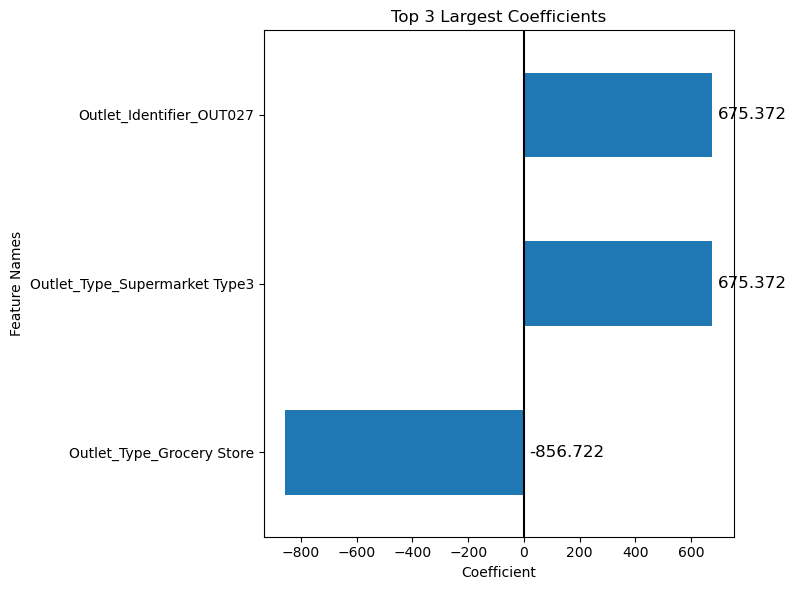

In [169]:
#Extract and visualize the coefficients that the LinearRegrssion model determine
ax = plot_coeffs(coeffs, top_n=3, annotate=True);

### Coefficients Interpreted

* If the `outlet_identifier_OUT027` feature increases by 1 unit it will increase the outlet sales by at 675. This outlet seems to have a significant positive impact on sales, possibly due to factors like its location, size, marketing strategies, or product assortment.
* If we increase the `outlet-location-type-tier3` feature by 1 unit it increases outlet sales 675. This could imply that products sold in locations categorized as "Tier 3" have a positive impact on sales, possibly due to factors like demographics, local preferences, or economic conditions.

* If we decrease the `outlet-type_grocery_store` by 1 unit it decreases the outlet sales by 856.  This might indicate that "Grocery Store" outlets have a negative impact on sales, possibly due to factors like limited product variety, lower foot traffic, or pricing strategies.

### Saving Linear Regression Plot


In [170]:
#save the coefficient figure as a file
fig = ax.get_figure()
fig.savefig("images/plot_linreg_coefficients.png", dpi=100)

## Tree-Based Model

In [171]:
## fit random forest
reg = RandomForestRegressor()
reg.fit(X_train_df,y_train)
#Custom functions for getting r2, rsme metrics
evaluate_regression(reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.94	RMSE= 427.68
Test Data:	R^2= 0.56	RMSE= 1099.59


In [172]:
#Defining a Function for Feature Importance
def get_importances(model, feature_names=None, name="Feature Importance",
                    sort=False, ascending=True):
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_

    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index=feature_names, name=name)
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)

    return importances

In [173]:
#Create a custom function to plot our importances
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    fig2, ax = plt.subplots()
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    plt.tight_layout();
    ## return ax in case want to continue to update/modify figure
    return ax

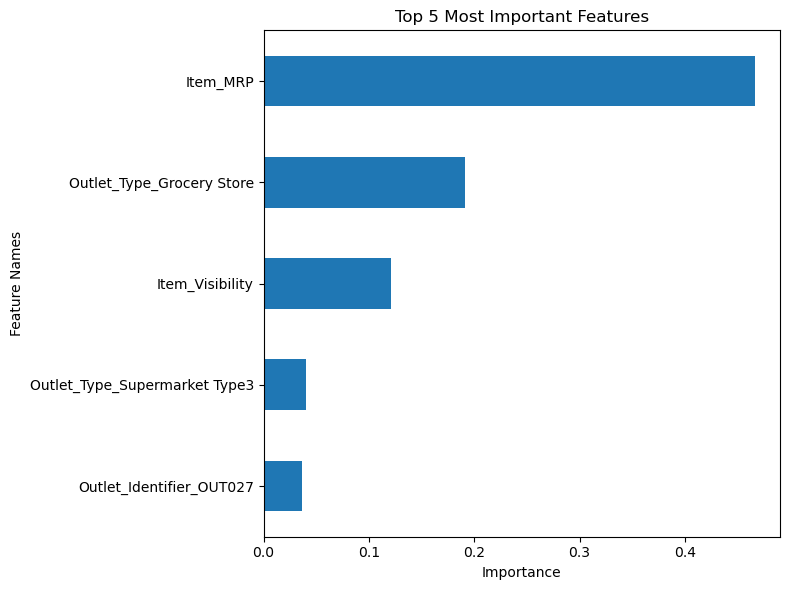

In [174]:
## Saving the feature importances
importances = get_importances(reg)
feature_importance_plot = plot_importance(importances, top_n=5);

### Feature Importance Explanation

 Higher importance values means a feature has a stronger impact on this model's predictions.
* The item's MRP (maximum retail price) has the strongest impact (.467) on the prediction of sales.
* Outlet Type Grocery Store has the 2nd strongest impact on the prediction of sales with .192.
* An item's visibility has the 3rd strongest impact on prediction of sales with .121.
* Outlet 027 has a significant impact on the prediction of sales with .043.
* Supermarket Type3 has a significant impact on the prediction of sales with .033.

In [175]:
#save the 5 most important features as a file
fig2 = feature_importance_plot.get_figure()
fig2.savefig("images/plot_rf_important_features.png", dpi=100)

# Serialize Your Best Models with Joblib

## Saving & Loading Models (joblib)

In [176]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
          'LinearRegression': lin_reg,
         'RandomForest':reg}
joblib.dump(export, 'Data/best-models.joblib')

['Data/best-models.joblib']

# Local Explanations

## Filtering Based on Final Class

In [177]:
#getting range of our target (y = df2["Item_Outlet_Sales"])
y.describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

In [178]:
#Separating low and high sales based on mean
low_sales = df2["Item_Outlet_Sales"] < 2181
high_sales = df2["Item_Outlet_Sales"] > 2181
df2[low_sales]

,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228
2,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700
3,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Tier 3,Grocery Store,732.3800
4,0.000000,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052
5,0.000000,Baking Goods,51.4008,OUT018,Medium,Tier 3,Supermarket Type2,556.6088
...,...,...,...,...,...,...,...,...
8516,0.118661,Others,58.7588,OUT018,Medium,Tier 3,Supermarket Type2,858.8820
8519,0.046982,Baking Goods,108.1570,OUT045,NaN,Tier 2,Supermarket Type1,549.2850
8520,0.035186,Health and Hygiene,85.1224,OUT035,Small,Tier 2,Supermarket Type1,1193.1136
8521,0.145221,Snack Foods,103.1332,OUT018,Medium,Tier 3,Supermarket Type2,1845.5976


In [179]:
#Separting high ITEM MRP based on 75% percentile
high_mrp = df2["Item_MRP"] > 185
low_mrp = df2["Item_MRP"] < 185
df2[high_mrp]

,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380
9,0.094450,Frozen Foods,187.8214,OUT017,NaN,Tier 2,Supermarket Type1,4710.5350
14,0.068024,Fruits and Vegetables,196.4426,OUT013,High,Tier 3,Supermarket Type1,1977.4260
19,0.102492,Dairy,230.5352,OUT035,Small,Tier 2,Supermarket Type1,2748.4224
20,0.138190,Snack Foods,250.8724,OUT013,High,Tier 3,Supermarket Type1,3775.0860
...,...,...,...,...,...,...,...,...
8508,0.043246,Fruits and Vegetables,199.4742,OUT045,NaN,Tier 2,Supermarket Type1,2587.9646
8509,0.214306,Fruits and Vegetables,213.9902,OUT010,NaN,Tier 3,Grocery Store,424.7804
8510,0.056862,Snack Foods,231.5984,OUT035,Small,Tier 2,Supermarket Type1,7182.6504
8511,0.026980,Frozen Foods,262.5910,OUT018,Medium,Tier 3,Supermarket Type2,4207.8560


In [188]:
## Get filter for all group with high sales and high mrp
filt_grp_high_sales_high_mrp = high_sales & high_mrp
filt_grp_high_sales_high_mrp.sum()

1543

In [189]:
## Get filter for all group Low sales & high mrp
filt_grp_low_sales_high_mrp = low_sales & high_mrp
filt_grp_low_sales_high_mrp.sum()

627

As we can see above, in high_mrp group we have:

* 1,543 outlets that earn high outlet sales

* 627 outlets that earn low outlet sales

In [190]:
## Get filter for all group with high sales and low mrp
filt_grp_high_sales_low_mrp = high_sales & low_mrp
filt_grp_high_sales_low_mrp.sum()

1986

In [191]:
## Get filter for all group with low sales and low mrp
filt_grp_low_sales_low_mrp = low_sales & low_mrp
filt_grp_low_sales_low_mrp.sum()

4367

As we can see above, in low_mrp group we have:

* 1,986 outlets that earn high outlet sales

* 4,367 outlets that earn low outlet sales

## Select one example of each for further exploration


### High MPR : Low Sales

Obtain the index value of high drinkers who passed:

In [196]:
## Selecting indices of outlets with high mpr and low sales
idx_examples_grp_low_sales_high_mpr = df2[filt_grp_low_sales_high_mrp].index
idx_examples_grp_low_sales_high_mpr

Int64Index([  14,   22,   49,   65,   67,   83,   96,   99,  108,  110,
            ...
            8375, 8410, 8419, 8428, 8435, 8449, 8458, 8477, 8505, 8509],
           dtype='int64', length=627)

In [197]:
## selecting random index of low sales w/ high mpr group
i_grp_low_sales_high_mpr = 8375 
# or use np.random.choice(idx_examples_grp_high_Pass)
example_grp_low_sales_high_mpr = df2.loc[i_grp_low_sales_high_mpr]
example_grp_low_sales_high_mpr

Item_Visibility                   0.104784
Item_Type               Health and Hygiene
Item_MRP                          266.0226
Outlet_Identifier                   OUT019
Outlet_Size                          Small
Outlet_Location_Type                Tier 1
Outlet_Type                  Grocery Store
Item_Outlet_Sales                 528.6452
Name: 8375, dtype: object

This individual sample shows the values for an outlet from the high-item-MPR group but low sales.

### High MPR: High Sales

In [198]:
## Selecting indices of outlets with high mpr and high sales
idx_examples_grp_high_sales_high_mpr = df2[filt_grp_high_sales_high_mrp].index
idx_examples_grp_high_sales_high_mpr

Int64Index([   0,    9,   19,   20,   32,   40,   42,   43,   47,   53,
            ...
            8485, 8491, 8493, 8496, 8502, 8506, 8508, 8510, 8511, 8518],
           dtype='int64', length=1543)

In [199]:
## selecting random index of high sales w/ high mpr group
i_grp_high_sales_high_mpr = 8485  
# or use np.random.choice(idx_examples_grp_high_Pass)
example_grp_high_sales_high_mpr = df2.loc[i_grp_high_sales]
example_grp_high_sales_high_mpr

Item_Visibility                  0.043792
Item_Type                     Soft Drinks
Item_MRP                          189.053
Outlet_Identifier                  OUT027
Outlet_Size                        Medium
Outlet_Location_Type               Tier 3
Outlet_Type             Supermarket Type3
Item_Outlet_Sales                6261.849
Name: 8485, dtype: object

This individual sample shows the values for an outlet that has high item MPR and high sales.

### Low MRP: High Sales
We will repeat the process to select an outlet from the low-item-MPR group:

In [206]:
## Selecting indices of low mpr w/ high sales
idx_examples_grp_high_sales_low_mrp = df2[filt_grp_high_sales_low_mrp].index
idx_examples_grp_high_sales_low_mrp

Int64Index([   7,   11,   18,   21,   24,   31,   35,   36,   46,   48,
            ...
            8487, 8488, 8492, 8495, 8497, 8499, 8503, 8504, 8512, 8517],
           dtype='int64', length=1986)

In [211]:
## Select a random index from the list.
i_grp_high_sales_low_mrp = np.random.choice(idx_examples_grp_high_sales_low_mrp)
i_grp_high_sales_low_mrp = 8487
example_grp_high_sales_low_mrp = df2.loc[i_grp_high_sales_low_mrp]
example_grp_high_sales_low_mrp.head()

Item_Visibility         0.037006
Item_Type            Soft Drinks
Item_MRP                164.7526
Outlet_Identifier         OUT027
Outlet_Size               Medium
Name: 8487, dtype: object

### Low MRP: Low Sales 

In [212]:
## Selecting indices of Group A students who failed
# high drinks that failed, 3 students output list of indexes
idx_examples_grp_low_sales_low_mrp = df2[filt_grp_low_sales_low_mrp].index
idx_examples_grp_low_sales_low_mrp

Int64Index([   1,    2,    3,    4,    5,    6,    8,   10,   12,   13,
            ...
            8501, 8507, 8513, 8514, 8515, 8516, 8519, 8520, 8521, 8522],
           dtype='int64', length=4367)

In [213]:
## Select a random index from the list.
i_grp_low_sales_low_mrp = np.random.choice(idx_examples_grp_low_sales_low_mrp)
i_grp_low_sales_low_mrp = 8501
example_grp_low_sales_low_mrp = df2.loc[i_grp_low_sales_low_mrp]
example_grp_low_sales_low_mrp.head()

Item_Visibility         0.005998
Item_Type            Snack Foods
Item_MRP                100.4358
Outlet_Identifier         OUT017
Outlet_Size                  NaN
Name: 8501, dtype: object